# Title

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler

from models.unet import UNet
from models.autoencoder import Autoencoder
from models.class_conditioned_unet import ClassConditionedUnet
from utils.evaluate_autoencoder import evaluate_autoencoder
from utils.evaluate_diffusion import evaluate_diffusion_model
from utils.helpers import plot_sample_noise
from trainers.train_diffusion import train_denoise_diffusion, train_conditional_diffusion

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/Users/jkosciukiewicz/miniconda3/envs/NeuralRendering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
# Add noise to the input images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, -1.0, 1.0)  # Keep pixel values in [-1, 1]

In [3]:
# Customowy MNIST z zaszuionymi obrazami
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        #AddNoiseTransform(noise_level=0.2),  # Add noise to the images
    ])
)
train_set, test_set = torch.utils.data.random_split(dataset, [50000, 10000])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True)

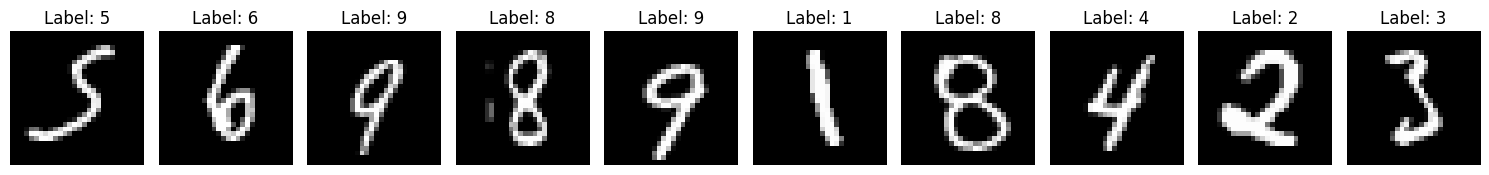

In [4]:
#plot the noisy image
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img, label = train_set[i]  # Get the image and label
    img = img.squeeze(0).numpy()  # Remove channel dimension and convert to numpy
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# Szum (Noise)

![Unet](./images/noise.jpg)
<br>
Szum to dodatkowe informacje, które nie są związane z obiektem obserwowanym. W przypadku obrazów cyfrowych szum to dodatkowe piksele, które nie są częścią obrazu. Mogą być one spowodowane zakłóceniami wynikającymi z konstukcji urządzenia przechwytującego obraz albo parametrów ekspozycji, wysokie ISO i słabe oświetlenie zazwyczaj prowadzą do zwiększenia szumu. Szum może pojawić się również na skutek obróbki obrazu, kompresji albo upscalingu.
<br>
Obecność szumu powoduje spadek jakości obrazu i oraz utratę zawartych w nim informacji, gdyż oryginalne wartości pixeli są zastępowane przez wartości losowe.

### Rodzaje szumu

### Jak zmierzyć szum?
Najczęściej stosowane są dwie metryki (dokładniejsze omówienie na zajęciach 3)
-   Peak Signal to Noise Ratio (PSNR)
-   Structural Similarity Index (SSIM)

### Rodzaje Szumów

1. **Szum Gaussowski**:

   **Opis**: Ten szum ma rozkład normalny, często nazywany "szumem białym". Przejawia się jako losowe fluktuacje w danych.

   - Symuluje błędy pomiarowe lub szumy z czujników, które mogą występować w rzeczywistym procesie pozyskiwania danych.
   - Pomaga modelom nauczyć się odporności, zmuszając je do identyfikowania ukrytych wzorców mimo małych wariacji.
   - Stosowany do augmentacji danych, sztucznie zwiększając rozmiar zbioru danych przez dodanie kontrolowanych wariacji szumowych.

2. **Szum Salt&Pepper**:

   **Opis**: Ten szum wprowadza losowe piksele o skrajnych wartościach intensywności, pojawiające się jako czarne (pepper) i białe (salt) plamki na obrazie.

   - Symuluje szumy impulsowe spowodowane awariami czujników lub błędami transmisji danych.
   - Pomaga modelom nauczyć się radzić sobie z danymi zawierającymi odstające wartości i nieciągłości.
   - Stosowany do testowania zdolności modelu do odzyskiwania danych po ich zniekształceniu.

3. **Szum Poissona**:

   **Opis**: Ten szum modeluje dane, w których liczba zdarzeń (np. liczenie fotonów w obrazie) podlega rozkładowi Poissona. Wprowadza wariacje oparte na średniej intensywności.

   - Istotny w zadaniach związanych z liczeniem fotonów lub warunkami niskiego oświetlenia, gdzie szum jest nieodłącznym elementem.
   - Pomaga modelom nauczyć się odpornych reprezentacji danych z wbudowaną losowością.

4. **Szum Plamkowy**:

   **Opis**: Często występuje w obrazach uzyskanych za pomocą radaru lub syntetycznego radaru aperturowego (SAR), wprowadza efekt mnożnikowy, często pojawiający się jako ziarnista tekstura.

   - Ważny w zadaniach związanych z analizą danych radarowych lub SAR, aby uwzględnić wbudowane wzorce szumowe.
   - Pomaga modelom nauczyć się odpornych cech w obrazach z szumem o charakterystyce mnożnikowej.


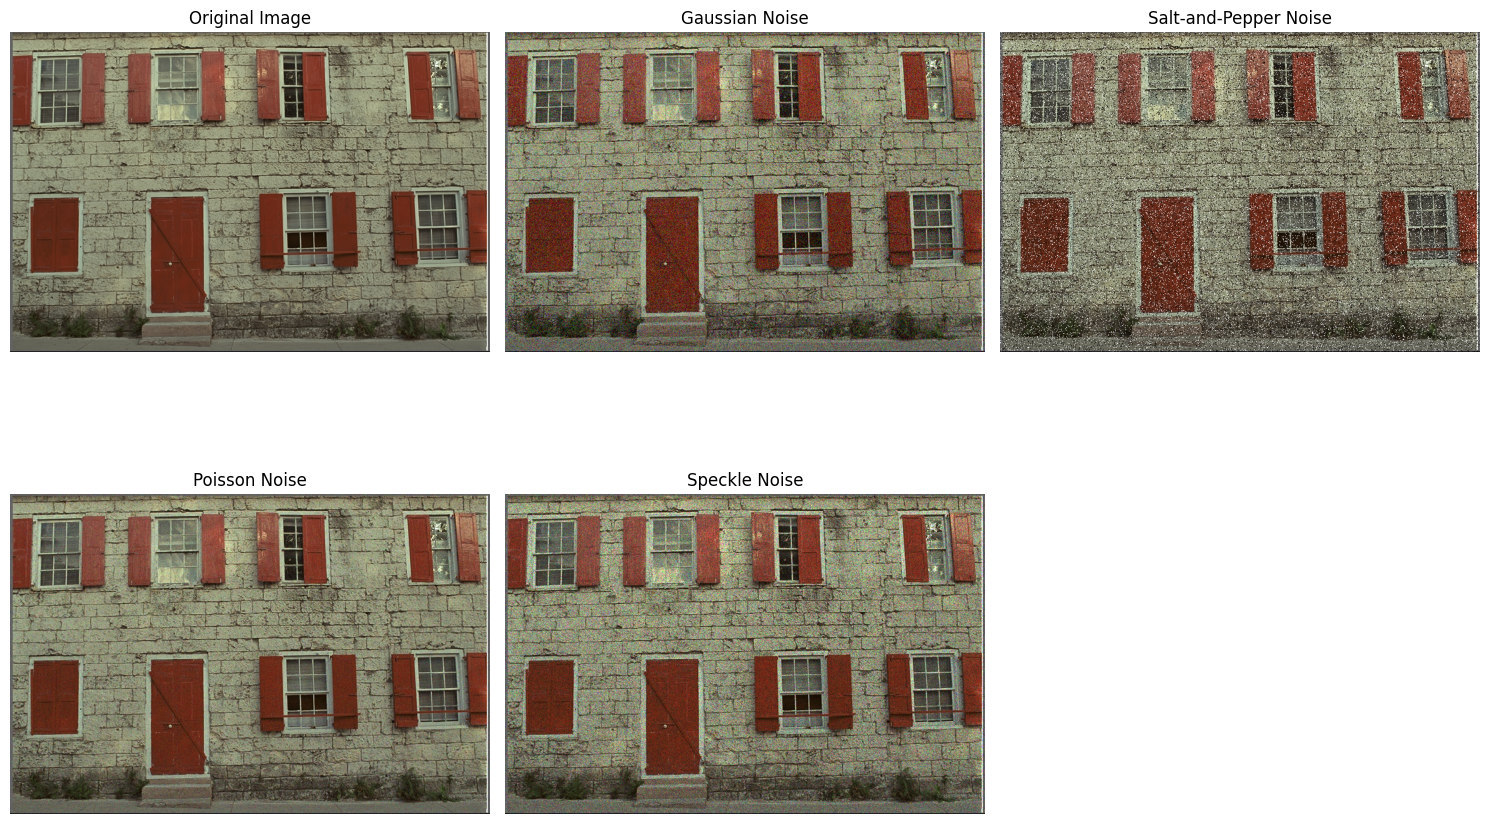

In [5]:
plot_sample_noise('./data/kodak/kodim01.png')

# Odszumianie

W celu odszumiania stosowany jest szeroki zakres metod, począwszy od prostych filtrów Gaussa rozmywających obraz w celu ukrycia szumów bo różnego rodzaju rozwiązania oparte o metody uczenia maszynowego. Pierwszą architekturą szeroko sosowaną do takiego celu były Autoenkodery.

## Autoenkoder

Autoenkodery to modele składające się z dwóch części - enkodera i dekodera. Enkoder koduje wejściowy obraz do reprezentacji ukrytej, z której dekoder jest następnie w stanie "odzyskać" źródłowy obraz. Powoduje to że autoenkodery bardzo dobrze sprawdzają się w scenariuszach kompresji danych.
<br>
<br>
![enc](./images/autoencoder.jpg)<br><br>
Autoenkodery trenujemy minimalizując loss pomiędzy obrazkiem wejściowym a wyjściowym -> chcemy żeby to co jest na wyjściu jak najbardziej przypominało to co jest na wejściu, ale co gdyby spróbować dodac do danych wejściowych szum ale loss dalej liczyć względem odszumionego obrazka?
<br>
<br>
![enc](./images/denoise.jpg)<br><br>
Okazuje się, że po tej niewielkiej modyfikacji autoenkoder zamienia się w model, który całkiem skutecznie odszumia dane !

In [6]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
epochs = 10

Zmodyfikowaliśmy trening autoencodera, tak aby dodać szum do przykładów treningowych, celem jest minimalizowanie kosztu pomiędzy rekonstrukcją obrazu a obrazem odszumionym -> w ten sposób jestesmy w stanie nauczyć autoenkoder odszumiania obrazków.

In [7]:
# Training loop
for epoch in range(epochs):
    model.train()
    for images, _ in train_dataloader:
        noisy_images = add_noise(images)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.2638
Epoch [2/10], Loss: 0.2369
Epoch [3/10], Loss: 0.1569
Epoch [4/10], Loss: 0.1216
Epoch [5/10], Loss: 0.0925
Epoch [6/10], Loss: 0.0860
Epoch [7/10], Loss: 0.0740
Epoch [8/10], Loss: 0.0655
Epoch [9/10], Loss: 0.0551
Epoch [10/10], Loss: 0.0544


Sprawdźmy jak poradził sobie model

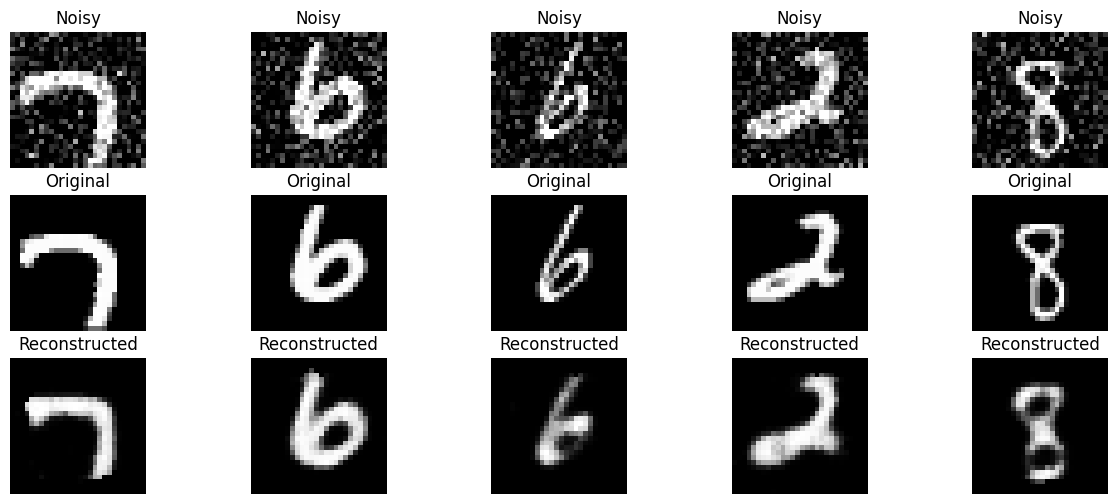

Average PSNR: 19.34
Average SSIM: 0.8290


In [8]:
model.eval()
avg_psnr, avg_ssim = evaluate_autoencoder(model, test_dataloader, add_noise, visualize=True)

Jak widać pomimo znacznego zaszumienia danych wejściowych, autoenkoder dość dobrze poradził sobie z ich odszumieniem.


## Diffusion
https://theaisummer.com/diffusion-models/

Modele dyfuzyjne najbardziej znane są z ich zastosowań generowania obrazków, np. StableDiffusion, działają na zasadzie systematycznego niszczenia struktury w rozkładzie danych poprzez iteracyjny proces dyfuzji.

1. **Forward diffusion** to proces, w którym model stopniowo wprowadza szum do obrazu (lub innego typu danych) w kilku krokach. Celem tego procesu jest zniszczenie oryginalnej struktury danych i przekształcenie obrazu w całkowity szum. Proces ten jest realizowany przez dodawanie losowego szumu do obrazu w wielu etapach. W każdym z tych kroków, oryginalny obraz staje się coraz bardziej zniekształcony, aż na końcu jest praktycznie nieodróżnialny od czystego szumu.

   - **Pierwszy krok**: Dodawanie niewielkiego szumu do obrazu. Na tym etapie obraz jest wciąż rozpoznawalny, ale jego struktura jest zaburzona.
   - **Kolejne kroki**: Szum jest dodawany w coraz większych ilościach. W miarę jak kolejne iteracje postępują, obraz staje się coraz bardziej nieczytelny.
   - **Ostatni krok**: Na koniec procesu obraz staje się praktycznie całkowitym szumem, bez żadnej struktury.

Forward diffusion pozwala modelowi na naukę, jak przekształcić obraz w szum, a następnie jak odbudować obraz z tego szumu.

![fwd](./images/forwad_diffusion.jpg)

2. **Reverse diffusion** to proces odwrotny do forward diffusion, który polega na odbudowywaniu oryginalnego obrazu z szumu. Model uczy się, jak krok po kroku "usunąć" szum z obrazu, przywracając go do jego pierwotnej formy. Proces ten jest znacznie trudniejszy, ponieważ model musi przewidzieć, jak wyglądał obraz w poprzednich krokach dyfuzji, aby skutecznie odbudować strukturę.

   - **Pierwszy krok**: Rozpoczynamy od obrazu, który jest całkowicie zaszumiony. Model przewiduje, jak wyglądałby obraz przed dodaniem szumu w jednym z wcześniejszych etapów.
   - **Kolejne kroki**: Model stopniowo usuwa szum, odtwarzając oryginalną strukturę obrazu w miarę postępu procesu.
   - **Ostatni krok**: Po wielu iteracjach, obraz jest już niemal identyczny z oryginalnym, zminimalizowano wpływ szumu.

Reverse diffusion wykorzystuje informacje zdobyte w procesie forward diffusion, aby odwrócić szum i odbudować dane. Model jest uczony, jak skutecznie przejść od całkowitego szumu do obrazu, zachowując przy tym jak najwięcej szczegółów i struktury.

![rvd](./images/backward_diffusion.jpg)

Jak widać, takie działanie modelu sugeruje, że sprawdzi się on dobrze przy odszumianiu obrazów.


In [12]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
epochs = 10

In [13]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [14]:
train_denoise_diffusion(model, train_dataloader, noise_scheduler, optimizer, criterion, epochs, device)

Epoch [1/10], Average loss: 0.611295
Epoch [2/10], Average loss: 0.468168
Epoch [3/10], Average loss: 0.445485
Epoch [4/10], Average loss: 0.437707
Epoch [5/10], Average loss: 0.431804
Epoch [6/10], Average loss: 0.428440
Epoch [7/10], Average loss: 0.425108
Epoch [8/10], Average loss: 0.422332
Epoch [9/10], Average loss: 0.418524
Epoch [10/10], Average loss: 0.418041


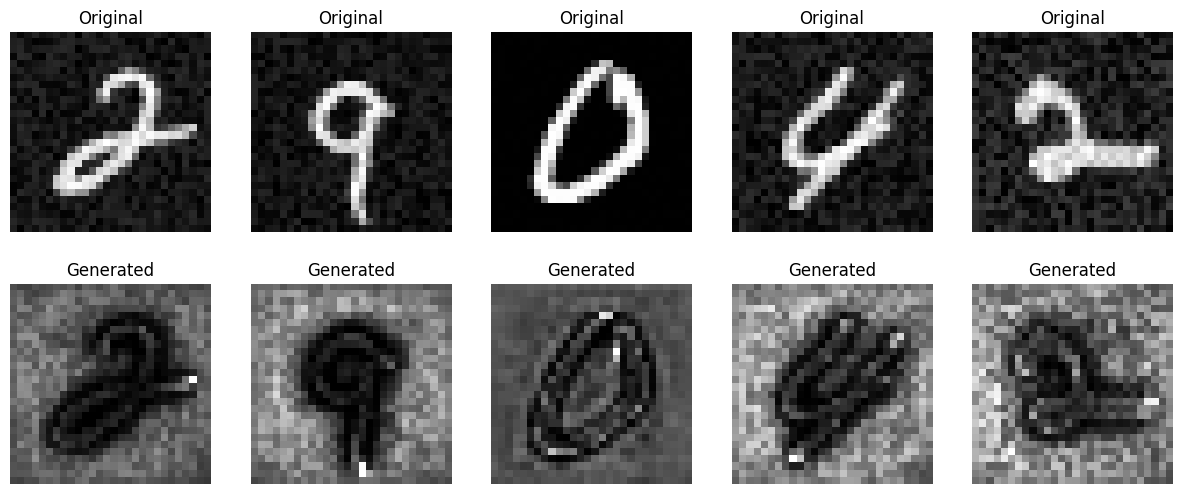

Average PSNR: 14.20
Average SSIM: 0.1992


In [15]:
evaluate_diffusion_model(model, test_dataloader,device,True)

# Modele Generatywne 2D

## Dyfuzja

W celu stworzenia z dyfucji modelu generatywnego do danych wejściowych dodajemy prompt - informacje która pozwoli nam warunkować wyjście modelu, w tym przypadku jest to prosty one-hot z informacją którą klasę należy wygenerować.

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [17]:
n_epochs = 10
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [18]:
train_conditional_diffusion(net,train_dataloader, noise_scheduler, optimizer, loss_fn, epochs, device)

KeyboardInterrupt: 

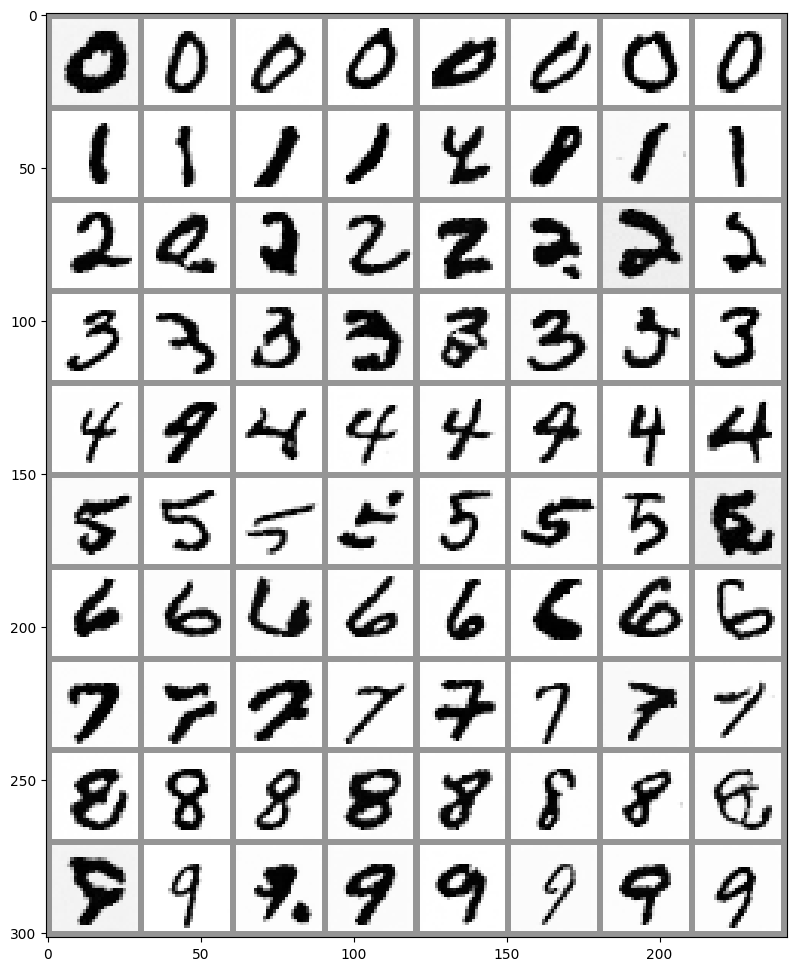

In [16]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

## Gany 3D
Modele typu GAN, choć pierwotnie zaprojektowane do generowania obrazów 2D, w połączeniu z technikami volume renderingu, takimi jak NeRF, stają się niezwykle skutecznym narzędziem do modelowania 3D. GANy wykorzystują latent space jako zredukowaną reprezentację danych, która jest mapowana na złożoną strukturę trójwymiarową. Pozwala to na kontrolowanie cech generowanych obiektów, takich jak kształt, tekstura, detale czy styl. Techniki te są szczególnie przydatne w generowaniu realistycznych modeli 3D.

W modelowaniu 3D GANy umożliwiają nie tylko generowanie nowych obiektów, ale także ich manipulację poprzez operacje w przestrzeni latentnej, co otwiera możliwości tworzenia personalizowanych i unikalnych modeli. W połączeniu z metodami, które eliminują konieczność precyzyjnych danych o pozycjach kamery, możliwe jest generowanie realistycznych struktur z szerokiej gamy danych.

#### HyperNeRFGAN
HyperNeRFGAN to przykład połączenia NeRFa z GAN-em w celu stworzenia generatywnego modelu 3D. Generator dostając na wejście wektor cech opisujaych wygląd modelu generuje wagi dla seci NeRF. Nastepnie Dyskryminator "ocenia" dokładność odwzorowania dla każdego wygenerowanego widoku, w ten sposób reprezentacja jest poprawiana, do momentu kiedy model zacznie generować realistyczne obiekty<br>
![nerfgan1](./images/nerfgan.jpg)
![nerfgan2](./images/cars.jpg)<br>
#### Niedeterministyczność
Wadą takich rozwiązań jest to że sa niedeterministyczne - w przypadku zastosowań takich modeli do rekonstrukcji danych np. z brakujacymi położeniami kamery model poradzi sobie dość dobrze, jednak wygenerowana reprezentacja za każdym razem będzie inna. W przypadku zastosowań np. medycznych jest to realny problem, który w połączeniu z bardzo długim czasem treningu oraz podatnością podatność na te same przypadłości co GAN-y (mode collapse itp) raczej dyskwalifikuje te modele z tego scenariusza. <br>
![nerfgan3](./images/knee.gif)<br>
![nerfgan4](./images/lung.gif)
<br>
<br>
